# Zadanie - predykcja profesji osoby na podstawie jej życiorysu

In [3]:
!pip install -U datasets

In [4]:
from datasets import load_dataset
import pandas as pd
import plotly.express as px
import re

## Zebranie i przygotowanie danych

### Wczytanie danych

In [ ]:
dataset = load_dataset("LabHC/bias_in_bios")
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.30k [00:00<?, ?B/s]

(…)-00000-of-00001-0ab65b32c47407e8.parquet:   0%|          | 0.00/64.9M [00:00<?, ?B/s]

(…)-00000-of-00001-5598c840ce8de1ee.parquet:   0%|          | 0.00/24.9M [00:00<?, ?B/s]

(…)-00000-of-00001-e6551072fff26949.parquet:   0%|          | 0.00/9.95M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/257478 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/99069 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/39642 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['hard_text', 'profession', 'gender'],
        num_rows: 257478
    })
    test: Dataset({
        features: ['hard_text', 'profession', 'gender'],
        num_rows: 99069
    })
    dev: Dataset({
        features: ['hard_text', 'profession', 'gender'],
        num_rows: 39642
    })
})


Podział danych na zbiór treningowy i testowy został już wykonany, w związku z czym nie musimy ręcznie dzielić danych.

In [ ]:
train_df = dataset['train'].to_pandas()
test_df = dataset['test'].to_pandas()
# Wypisanie danych wejściowych
train_df.head()

hard_text  profession  gender
0  He is also the project lead of and major contr...          21       0
1  She is able to assess, diagnose and treat mino...          13       1
2  Prior to law school, Brittni graduated magna c...           2       1
3  He regularly contributes to India’s First Onli...          11       0
4  He completed his medical degree at Northwester...          21       0

In [ ]:
train_df.sample(4)

hard_text  profession  gender
140024  She graduated with honors in 2005. Having more...          22       1
196011  His research and lecturing activities are focu...          21       0
89772   Initially based in Delhi, he moved to Bangalor...           1       0
26677   Before joining ACUS, Mr. Massaro worked as an ...           2       0

In [ ]:
# Sprawdzenie rozkładu atrybutu decyzyjnego
train_professions = train_df.groupby('profession').nunique()
test_professions = test_df.groupby('profession').nunique()

fig = px.bar(train_professions, y="hard_text", title="Rozkład profesji w danych treningowych")
fig.update_layout(xaxis={'dtick':1})
fig.show()
fig = px.bar(test_professions, y="hard_text", title="Rozkład profesji w danych testowych")
fig.update_layout(xaxis={'dtick':1})
fig.show()

W obu zbiorach danych rozkład wartości jest przybliżony. Klasy nie są równomiernie rozłożone - wyraźnie dominuje klasa 21 (profesor). Jest to zgodne z informacjami na huggingface, gdzie jest napisane, że ta klasa stanowi 29,8% przypadków.

### Preprocessing

Usunięcie duplikatów

In [ ]:
train_df.groupby('profession').nunique()

hard_text  gender
profession                   
0                3655       2
1                6554       2
2               21122       2
3                1707       2
4                1820       2
5                3634       2
6                9453       2
7                2563       2
8                 964       2
9                4541       2
10                947       2
11              12929       2
12               4862       2
13              12308       2
14               5021       2
15               1145       2
16               1636       2
17                927       2
18              15752       2
19              26620       2
20               4556       2
21              76660       2
22              11936       2
23                911       2
24               4483       2
25               8820       2
26              10517       2
27               1073       2

In [ ]:
train_df.drop_duplicates(subset=['hard_text'], inplace=True)
train_df.groupby('profession').nunique()

hard_text  gender
profession                   
0                3655       2
1                6553       2
2               21122       2
3                1700       2
4                1820       2
5                3634       2
6                9451       2
7                2563       2
8                 964       2
9                4541       2
10                947       2
11              12929       2
12               4862       2
13              12307       2
14               5021       2
15               1145       2
16               1636       2
17                927       2
18              15752       2
19              26616       2
20               4556       2
21              76659       2
22              11934       2
23                911       2
24               4483       2
25               8818       2
26              10517       2
27               1073       2

In [ ]:
test_df.groupby('profession').nunique()

hard_text  gender
profession                   
0                1409       2
1                2527       2
2                8135       2
3                 662       2
4                 703       2
5                1400       2
6                3633       2
7                 989       2
8                 372       2
9                1749       2
10                366       2
11               4982       2
12               1874       2
13               4734       2
14               1935       2
15                442       2
16                632       2
17                358       2
18               6067       2
19              10247       2
20               1754       2
21              29509       2
22               4594       2
23                351       2
24               1724       2
25               3396       2
26               4050       2
27                416       2

In [ ]:
test_df.drop_duplicates(subset=['hard_text'], inplace=True)
test_df.groupby('profession').nunique()

hard_text  gender
profession                   
0                1409       2
1                2527       2
2                8135       2
3                 658       2
4                 703       2
5                1400       2
6                3632       2
7                 989       2
8                 372       2
9                1749       2
10                366       2
11               4982       2
12               1874       2
13               4734       2
14               1935       2
15                442       2
16                632       2
17                358       2
18               6067       2
19              10245       2
20               1754       2
21              29509       2
22               4594       2
23                351       2
24               1724       2
25               3395       2
26               4050       2
27                416       2

In [ ]:
# Zamiana na małe litery
train_df['hard_text'] = train_df['hard_text'].apply(lambda x: x.lower())
test_df['hard_text'] = test_df['hard_text'].apply(lambda x: x.lower())
# Usunięcie linków
url_re = re.compile(r'((www.[^\s]+)|(https?://[^\s]+))')
train_df['hard_text'] = train_df['hard_text'].apply(lambda x: url_re.sub('', x))
test_df['hard_text'] = test_df['hard_text'].apply(lambda x: url_re.sub('', x))
# Usunięcie znaków interpunkcyjnych (oprócz apostrofu)
character_re = re.compile(r"[^a-z\s']")
train_df['hard_text'] = train_df['hard_text'].apply(lambda x: character_re.sub('', x))
test_df['hard_text'] = test_df['hard_text'].apply(lambda x: character_re.sub('', x))

train_df.head()

hard_text  profession  gender
0  he is also the project lead of and major contr...          21       0
1  she is able to assess diagnose and treat minor...          13       1
2  prior to law school brittni graduated magna cu...           2       1
3  he regularly contributes to indias first onlin...          11       0
4  he completed his medical degree at northwester...          21       0

In [6]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.4 MB/s eta 0:00:00


Rozwijanie skrótów - w tym celu wykorzystuję bibliotekę [contractions](https://pypi.org/project/pycontractions/)

In [7]:
import contractions
def expand_abbreviations(text):
  expanded_words = []
  for word in text.split():
    expanded_words.append(contractions.fix(word))
  return ' '.join(expanded_words)
train_df['hard_text'] = train_df['hard_text'].apply(expand_abbreviations)
test_df['hard_text'] = test_df['hard_text'].apply(expand_abbreviations)

Usuwanie stop words przy pomocy spacy:

In [ ]:
!echo "numpy<2.0" > constraints.txt

In [ ]:
!pip install -U spacy --constraint constraints.txt
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 66.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
nlp = spacy.load("en_core_web_md", disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

In [ ]:
def remove_stopwords(text):
    return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

train_df['hard_text'] = train_df['hard_text'].apply(remove_stopwords)
test_df['hard_text'] = test_df['hard_text'].apply(remove_stopwords)

In [ ]:
train_df.head()

hard_text  profession  gender
0  project lead major contributor open source ass...          21       0
1  able assess diagnose treat minor illness condi...          13       1
2  prior law school brittni graduate magna cum la...           2       1
3  regularly contribute india online muslim newsp...          11       0
4  complete medical degree northwestern universit...          21       0

Poprawa pisowni:

In [8]:
!pip install autocorrect

In [11]:
from autocorrect import Speller
spell = Speller(lang='en')

def fix_spelling(text):
  return spell(text)

train_df['hard_text'] = train_df['hard_text'].apply(fix_spelling)
test_df['hard_text'] = test_df['hard_text'].apply(fix_spelling)

Lematyzacja:

In [ ]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

train_df['hard_text'] = train_df['hard_text'].apply(lemmatize)
test_df['hard_text'] = test_df['hard_text'].apply(lemmatize)

In [ ]:
train_df.head()

hard_text  profession  gender
0  project lead major contributor open source ass...          21       0
1  able assess diagnose treat minor illness condi...          13       1
2  prior law school brittni graduate magna cum la...           2       1
3  regularly contribute india online muslim newsp...          11       0
4  complete medical degree northwestern universit...          21       0

Ponieważ lematyzacja długo trwa, zapisuję dane do pliku, by nie musieć jej powtarzać.

In [ ]:
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

In [5]:
# Wczytanie plików po zapisie
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

hard_text  profession  gender
0  project lead major contributor open source ass...          21       0
1  able assess diagnose treat minor illness condi...          13       1
2  prior law school brittni graduate magna cum la...           2       1
3  regularly contribute india online muslim newsp...          11       0
4  complete medical degree northwestern universit...          21       0

In [ ]:
# WordCloud - dla 3 najpopularniejszych klas
from wordcloud import WordCloud
most_popular_professions = train_df.groupby('profession').nunique().sort_values('hard_text', ascending=False).head(3)
print(f"Najbardziej popularne profesje: {most_popular_professions.index.values}")

Najbardziej popularne profesje: [21 19  2]


21


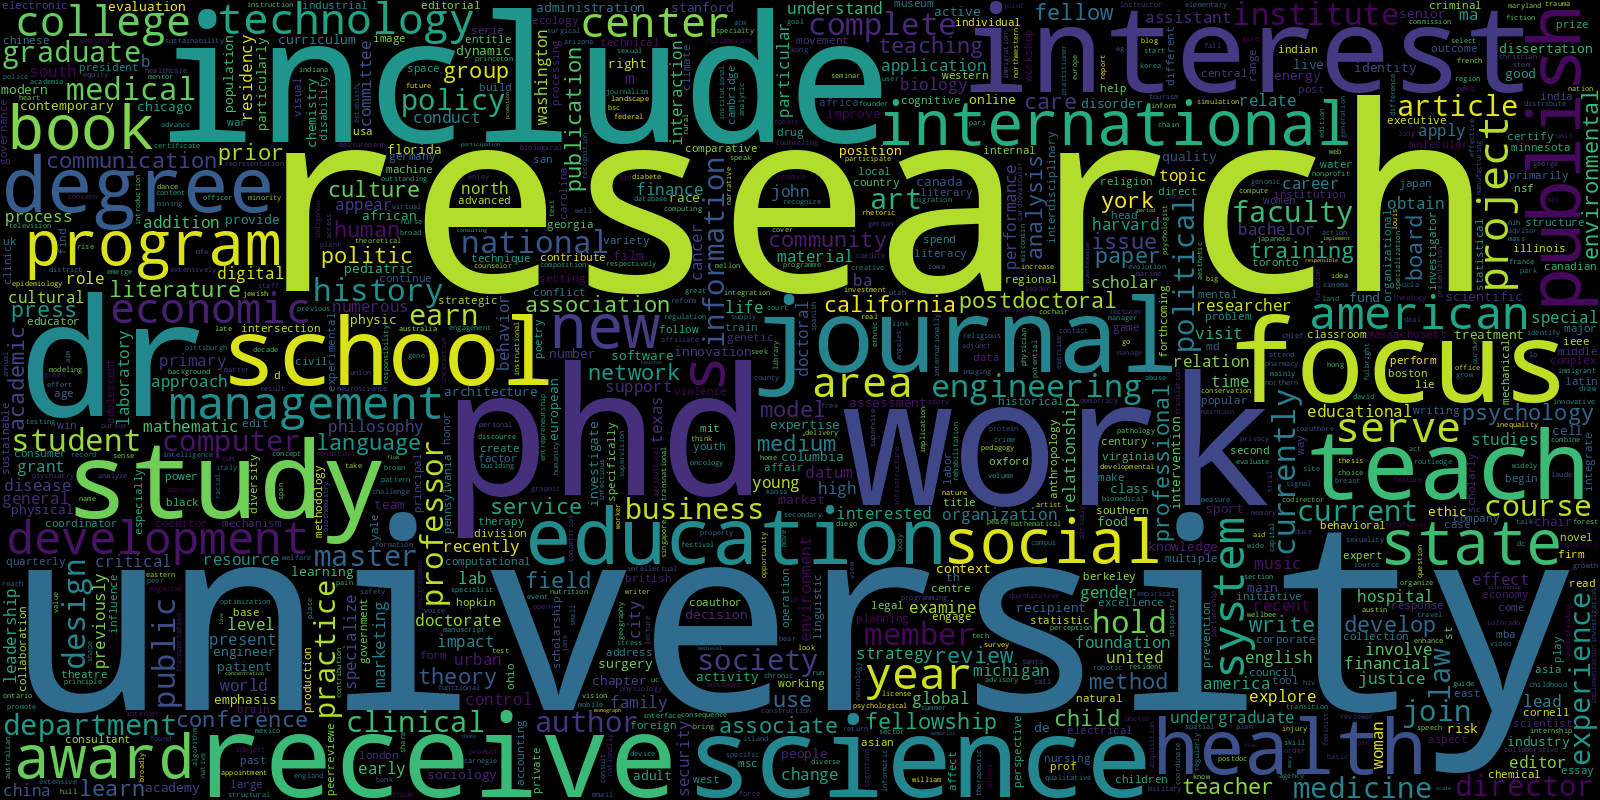

In [ ]:
print(most_popular_professions.index.values[0]) # 21 - profesor
text = ' '.join(train_df[train_df['profession']==most_popular_professions.index.values[0]]['hard_text'])
wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(text)
wc.to_image()

19


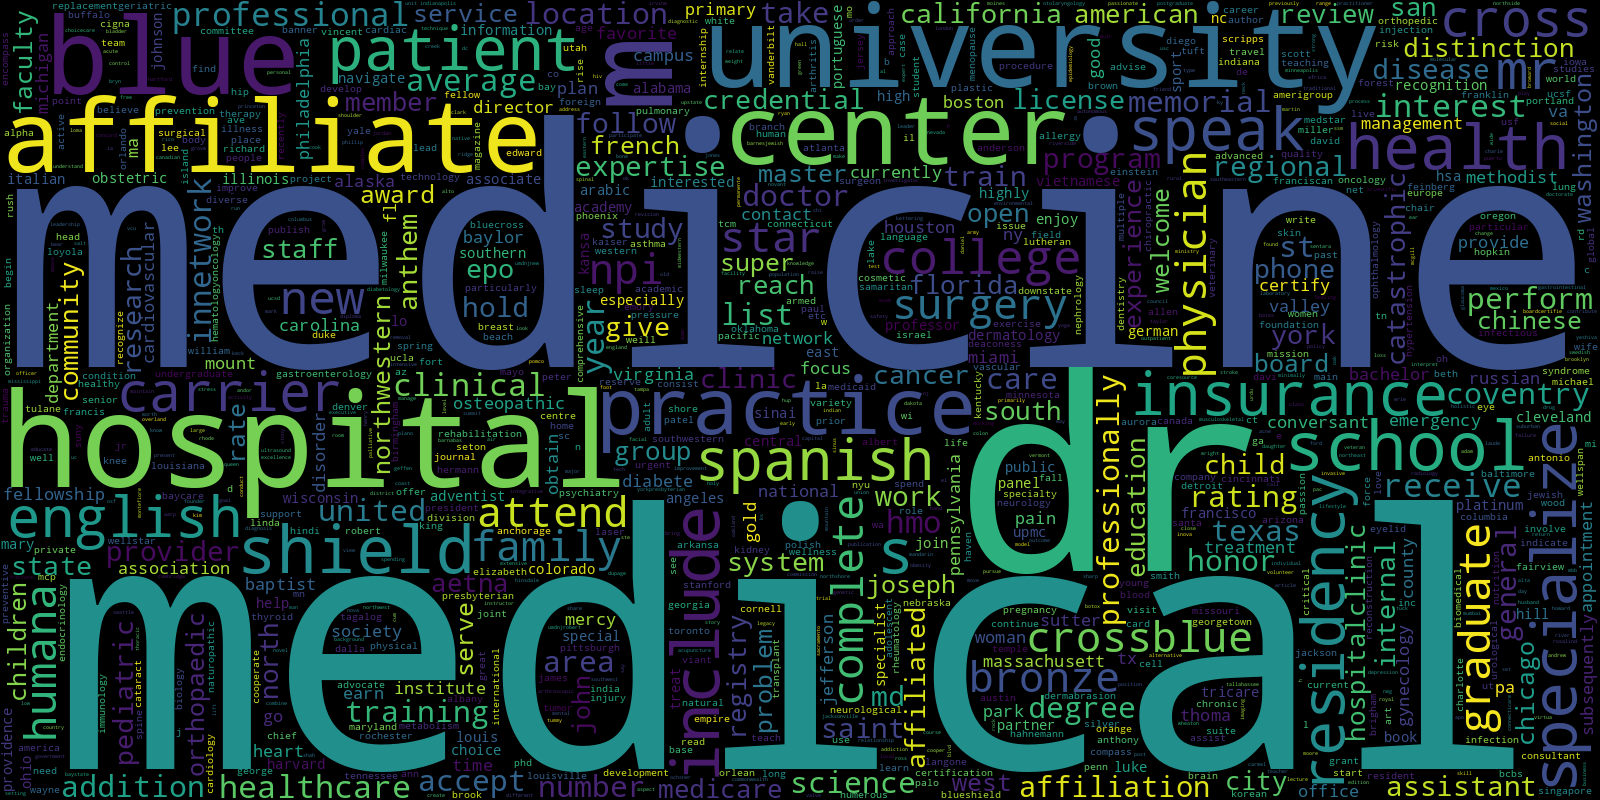

In [ ]:
print(most_popular_professions.index.values[1]) # 19 - lekarz (physician)
text = ' '.join(train_df[train_df['profession']==most_popular_professions.index.values[1]]['hard_text'])
wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(text)
wc.to_image()

2


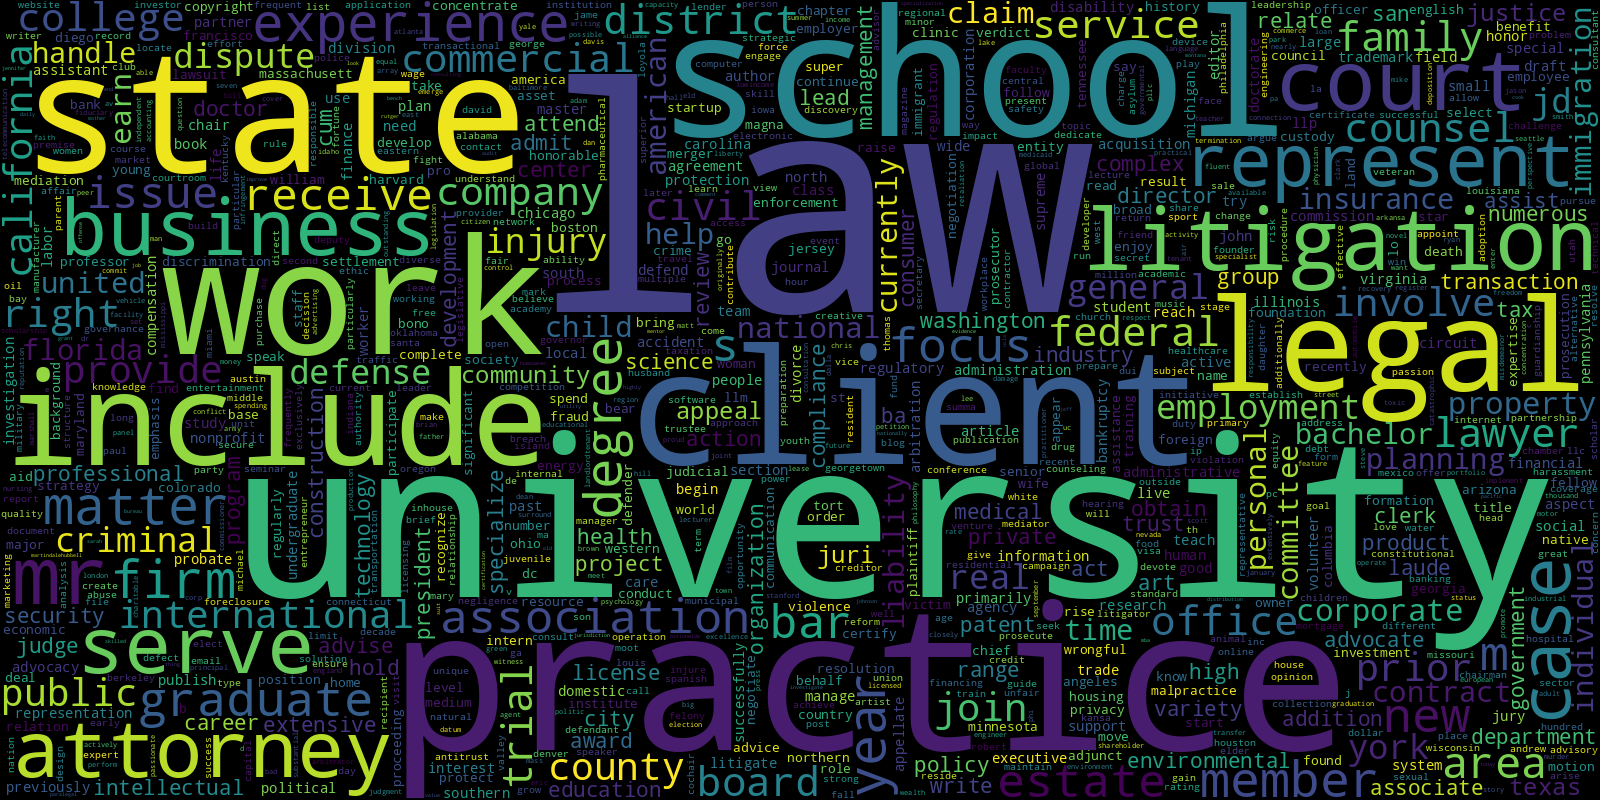

In [ ]:
print(most_popular_professions.index.values[2]) # 2 - prawnik (attorney)
text = ' '.join(train_df[train_df['profession']==most_popular_professions.index.values[2]]['hard_text'])
wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(text)
wc.to_image()

Słownictwo wyraźnie pomaga rozróżnić te 3 przykładowe zawody - profesorowie uczelni często mają słowa "university" i "research" w swoich życiorysach, u lekarzy najpopularniejszymi słowami są "medicine" i "medical", a u prawników najpopularniejszym słowem jest "law".

## Inżynieria cech

In [6]:
train_df.isna().sum()

hard_text     0
profession    0
gender        0
dtype: int64

In [7]:
test_df.isna().sum()

hard_text     0
profession    0
gender        0
dtype: int64

Żaden ze zbiorów danych nie ma brakujących wartości.

In [8]:
unique_words = set()
for text in train_df['hard_text']:
    for word in text.split():
        unique_words.add(word)
num_unique_words = len(unique_words)

In [9]:
num_unique_words

268162

In [10]:
max_text_length = 0
for text in train_df['hard_text']:
   if len(text) > max_text_length:
    max_text_length = len(text)
max_text_length

775

In [11]:
# Tokenizacja
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

tokenizer = Tokenizer(num_words=num_unique_words)
texts = train_df.hard_text.to_list()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index), end='\n\n')

train_data = pad_sequences(sequences, maxlen=max_text_length)
print(train_data)

# To samo dla zbioru testowego

texts = test_df.hard_text.to_list()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index), end='\n\n')

test_data = pad_sequences(sequences, maxlen=max_text_length)
print(test_data)

Found 268160 unique tokens

[[    0     0     0 ...   927   819 57800]
 [    0     0     0 ...   716   116 13394]
 [    0     0     0 ...   631   707  5643]
 ...
 [    0     0     0 ...  6722  3569  1920]
 [    0     0     0 ...   147   436   679]
 [    0     0     0 ...  5485  9760   239]]
Found 331158 unique tokens

[[    0     0     0 ...     3   250  1393]
 [    0     0     0 ...   536   387   159]
 [    0     0     0 ...  2440  7947  9695]
 ...
 [    0     0     0 ...   208 24875  3732]
 [    0     0     0 ...   396   311  3375]
 [    0     0     0 ...   474    13   584]]


Do przygotowania word embeddingu, wykorzystuję Glove.

In [12]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2025-01-05 18:44:51--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-01-05 18:44:51--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1      100%[===================>] 822.24M  5.83MB/s    in 2m 39s  

2025-01-05 18:47:31 (5.16 MB/s) - ‘glove.6B.zip.1’ saved [862182613/862182613]



In [26]:
from zipfile import ZipFile
with ZipFile('glove.6B.zip', 'r') as z:
  z.extractall()

In [13]:
import numpy as np
embeddings_index = dict()
f = open('./glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print(f'Loaded {len(embeddings_index)} word vectors.')

Loaded 400000 word vectors.


In [14]:
vocab = tokenizer.sequences_to_texts(texts)
vocab_size = len(tokenizer.word_index) + 1 # Dodajemy 1 bo indeks 0 jest już zarezerwowany
print(vocab_size)

# tworzymy macierz
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

331159


## Trenowanie modelu - klasyczne ML

**TODO: Dodać możliwość podania parametru płci do modelu**

In [15]:
from keras.models import Sequential, Model
from keras import layers
model = Sequential()
num_classes = 28

model.add(layers.Input(shape=(max_text_length,), dtype='int32', name='review_input'))
model.add(layers.Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix], input_length=max_text_length, trainable=True))
model.add(layers.Flatten())
model.add(layers.Dense(units=200, activation='relu'))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dense(units=num_classes, activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [16]:
X_train = train_data
y_train = pd.get_dummies(train_df['profession'], dtype=int).to_numpy()
X_test = test_data
y_test =  pd.get_dummies(test_df['profession'], dtype=int).to_numpy()

In [17]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
from tensorflow.config import run_functions_eagerly

# tf.config w celu uniknięcia ValueError: Creating variables on a non-first call to a function decorated with tf.function.
run_functions_eagerly(True)

history = model.fit(X_train,
          y_train,
          epochs=5,
          batch_size=1024,
          verbose=True,
          validation_data=(X_test, y_test))

Epoch 1/5
  3/252 ━━━━━━━━━━━━━━━━━━━━ 1:10:34 17s/step - accuracy: 0.1262 - loss: 3.9381

KeyboardInterrupt: 